What is the agent learning? Well just the identity map... It's pretty straightforward, since it's a delta.


If we put as state the note played before, and the target is to learn the next note to play

In [28]:
import numpy as np
import matplotlib.pyplot as plt 
from IPython.display import display, HTML
from tqdm import tqdm
import os
import pandas as pd

class Record:
    def __init__(self, T_0, notes_to_choose = 5):
        self.notes_to_choose = notes_to_choose
        self.transitions = [T_0]
        self.trajectories = []
    

In [171]:
       
class Agent():
    def __init__(self, notes_to_choose, gamma=0., ep=0.01, index=0, lowest_key=0):

        self.states = notes_to_choose
        self.n_actions = notes_to_choose
        
        self.q = np.ones((notes_to_choose, notes_to_choose))
        self.n = np.ones((notes_to_choose, notes_to_choose))
        
        self.lowest_key=lowest_key ##this will shift the scale of 12 notes
        
        self.epsilon = ep
        self.gamma = gamma
        self.index = index
        self.qtables_history=[]
        self.reward_history=[]
        self.trajectories=[]
        
        self.shift_to = lambda melody: melody[1:] + [melody[0]]
        self.shift_back = lambda melody: [melody[-1]] + melody[:-1]
    
        np.random.seed(self.index)
        
    def give_action(self, state, greedy=False):
        if np.random.random()<self.epsilon and (greedy == False):
            return np.random.choice(range(self.n_actions), 1)[0]
        else:
            qs = self.q[state,:]
            qs = np.where( qs == np.max(qs) )[0]
            return np.random.choice(qs, 1)[0]

    def get_reward(self, guess, label):
        if guess == label:
            return 1
        else:
            return 0
        
    def q_learn(self, ts):
        ### q-learn (bandit)
        self.qtables_history.append(self.q.copy())
        for interaction in ts:
            s, a, r, ns = interaction
            self.reward_history.append(r)
            self.n[s,a]+=1
            self.q[s,a] += (r- self.q[s,a])/self.n[s,a]
        
    def decrease_ep(self,ind, tau=500):
        self.epsilon = max(self.epsilon*np.exp(-(ind+1)/tau), 0.01)
        return
    
    def give_melody(self, melody):
        note_player=[]
        for ind,note in enumerate(melody):
            note_player.append(self.give_action(note, greedy=True))
        return note_player
    
    def learn_melody(self, melody, N=50):
        #in case the melody is more agudo (we always keep to 12 notes)
        print(melody)
        melody = list(np.array(melody) - self.lowest_key)
        #we shift the melody by one note. The agent hears the first note, and should reconstruct the entire melody.
        shifted_melody = np.array(self.shift_to(melody) )
        for episode in tqdm(range(N)):
            ts=[]
            #So the agent hears the first one.
            state = melody[0]
            actions=[]
            #and then it loops for the other tones in the melody (at the final note, it should get the first one)
            for note in shifted_melody:
                action = self.give_action(state)
                actions.append(action)
                reward = self.get_reward(action,note)
                
                ## transition rule (easy case!)
                next_state = note
                ts.append([state, action, reward, next_state])
                state = next_state ### and back to the loop!

            self.q_learn(ts)
            self.decrease_ep(episode)
            self.trajectories.append(np.array(self.shift_back(actions)) + self.lowest_key)
            
    def get_cumulative(self):
        return np.cumsum(self.reward_history)/np.arange(1,len(self.reward_history)+1)
    
    def get_learning_curve(self):
        plt.figure(figsize=(10,10))
        plt.plot(self.get_cumulative(), linewidth=15, alpha=0.7,color="red")
        plt.xlabel("Episodes",size=30)
        plt.ylabel("Cumulative rewards", size=30)
        plt.xticks(size=20)
        plt.yticks(size=20)
        plt.title("Learning curve", size=30)

In [172]:
agents = {}
major=[0,3,5]
minor=[0,2,5]
for ind in range(3):
    agents[ind] = Agent(12, gamma=0., ep=1, index=ind, lowest_key=major[ind])
    agents[ind].melody = np.array([0,3,5,7])+major[ind]
    agents[ind].learn_melody(agents[ind].melody,N=50)

100%|██████████| 50/50 [00:00<00:00, 4583.04it/s]

[0 3 5 7]
[ 3  6  8 10]
[ 5  8 10 12]


In [175]:
for agent in agents.values():
    os.makedirs("AIdata/agent{}/".format(agent.index), exist_ok=True)
    for ind, traj in enumerate(agent.trajectories):
        np.savetxt("AIdata/agent{}/episode{}.csv".format(agent.index, ind),np.array([traj]).astype(int)+60, fmt='%i', delimiter=",")

[0 3 5 7]
[ 3  6  8 10]
[ 5  8 10 12]


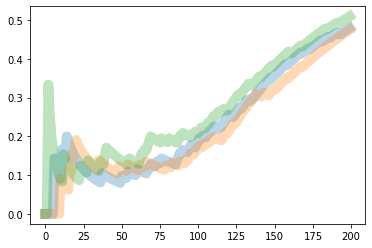

In [176]:
for agent in agents.values():
    plt.plot(agent.get_cumulative(), linewidth=10, alpha=0.3)
    print(agent.trajectories[-1])